In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
50789,7373665,1,37465,14,9.0,917.0,317.678261,295.0,212.453107,0.0,...,0,0,0,1,0,0,0,0,0,396
79986,3316706,2842,9114,35,0.0,44.0,4.466374,2.0,7.145136,0.0,...,1,0,0,0,0,0,0,0,1,1
47569,157959,0,175,18,0.0,66.0,13.704545,9.0,13.262638,0.0,...,0,0,0,0,0,0,0,0,1,1
22908,700738,0,1600,34,0.0,62.0,5.605660,2.0,9.855616,0.0,...,0,1,0,1,0,0,0,0,0,0
166357,43776,0,42,36,0.0,32.0,8.260000,6.0,8.024488,0.0,...,0,0,0,0,0,1,0,0,0,1
22915,700738,0,1600,34,0.0,62.0,5.605660,2.0,9.855616,0.0,...,0,0,0,0,0,0,0,1,0,1
7783,2035731,0,6523,14,0.0,184.0,26.146154,11.5,41.253832,0.0,...,0,0,0,0,0,0,0,1,0,0
136263,2001197,0,1053,2,0.0,223.0,25.997691,16.0,35.022296,0.0,...,0,0,0,0,0,1,0,0,0,0
38924,4072194,880,161174,9,0.0,2219.0,147.955342,78.0,217.664556,0.0,...,0,0,0,0,0,0,0,1,0,1
11771,3544586,122388,227617,9,0.0,1546.0,144.377739,95.0,184.181892,0.0,...,0,0,0,0,0,0,0,1,0,7


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
# base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
#                           + training_dataset["Base DateTime weekday-Tuesday"]
#                           + training_dataset["Base DateTime weekday-Wednesday"]
#                           + training_dataset["Base DateTime weekday-Thursday"]
#                           + training_dataset["Base DateTime weekday-Friday"]).astype("int")
# base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
#                           + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
# training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
# training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
# training_dataset.drop(
#     ["Base DateTime weekday-Saturday",
#      "Base DateTime weekday-Sunday",
#      "Base DateTime weekday-Monday",
#      "Base DateTime weekday-Tuesday",
#      "Base DateTime weekday-Wednesday",
#      "Base DateTime weekday-Thursday",
#      "Base DateTime weekday-Friday"], axis = 1, inplace = True)
# training_dataset

In [7]:
features = training_dataset.iloc[:, :48]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,H Local,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,0,1,0,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Stacking Regressor

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, min_samples_split=2, learning_rate=0.5, n_estimators=100):
    # LGBMRegressor
    lgbmr_model = LGBMRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # HistGradientBoostingRegressor
    hgbr_model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        random_state=42,
    )
    
    # RandomForestRegressor
    rfr_model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # BaggingRegressor
    br_model = BaggingRegressor(
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # XGBRegressor
    xgbr_model = XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # GradientBoostingRegressor
    gbr_model = GradientBoostingRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # ExtraTreesRegressor
    etr_model = ExtraTreesRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # CatBoostRegressor
    cbr_model = CatBoostRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # StackingRegressor
    model = StackingRegressor(estimators=[('lgbmr', lgbmr_model),
                                          ('hgbr', hgbr_model),
                                          ('rfr', rfr_model),
                                          ('br', br_model),
                                          ('xgbr', xgbr_model),
                                          ('gbr', gbr_model),
                                          ('etr', etr_model),
                                          ('cbr', cbr_model)])

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

0:	learn: 33.4023853	total: 243ms	remaining: 14.3s
1:	learn: 31.7282411	total: 410ms	remaining: 11.9s
2:	learn: 30.2286754	total: 596ms	remaining: 11.3s
3:	learn: 28.9460989	total: 804ms	remaining: 11.3s
4:	learn: 27.6947959	total: 996ms	remaining: 11s
5:	learn: 26.6657917	total: 1.18s	remaining: 10.7s
6:	learn: 25.6345631	total: 1.36s	remaining: 10.3s
7:	learn: 24.7878252	total: 1.55s	remaining: 10.1s
8:	learn: 24.0130660	total: 1.73s	remaining: 9.83s
9:	learn: 23.3135457	total: 1.91s	remaining: 9.56s
10:	learn: 22.6857655	total: 2.1s	remaining: 9.38s
11:	learn: 22.1123776	total: 2.29s	remaining: 9.15s
12:	learn: 21.5922588	total: 2.48s	remaining: 8.95s
13:	learn: 21.0858948	total: 2.65s	remaining: 8.71s
14:	learn: 20.6578295	total: 2.82s	remaining: 8.47s
15:	learn: 20.2446993	total: 3s	remaining: 8.24s
16:	learn: 19.8622878	total: 3.18s	remaining: 8.04s
17:	learn: 19.4917450	total: 3.36s	remaining: 7.83s
18:	learn: 19.1783337	total: 3.53s	remaining: 7.62s
19:	learn: 18.8790344	total:

39:	learn: 15.0094315	total: 7.98s	remaining: 3.99s
40:	learn: 14.8823059	total: 8.16s	remaining: 3.78s
41:	learn: 14.7561979	total: 8.34s	remaining: 3.58s
42:	learn: 14.6569187	total: 8.55s	remaining: 3.38s
43:	learn: 14.5609180	total: 8.76s	remaining: 3.19s
44:	learn: 14.4744911	total: 8.94s	remaining: 2.98s
45:	learn: 14.3985985	total: 9.15s	remaining: 2.78s
46:	learn: 14.3063773	total: 9.33s	remaining: 2.58s
47:	learn: 14.1955759	total: 9.51s	remaining: 2.38s
48:	learn: 14.1114509	total: 9.7s	remaining: 2.18s
49:	learn: 14.0280039	total: 9.92s	remaining: 1.98s
50:	learn: 13.9380279	total: 10.1s	remaining: 1.78s
51:	learn: 13.8590961	total: 10.3s	remaining: 1.58s
52:	learn: 13.7814778	total: 10.5s	remaining: 1.39s
53:	learn: 13.6767670	total: 10.7s	remaining: 1.19s
54:	learn: 13.5941701	total: 10.9s	remaining: 994ms
55:	learn: 13.5273568	total: 11.1s	remaining: 795ms
56:	learn: 13.4758456	total: 11.4s	remaining: 599ms
57:	learn: 13.3955092	total: 11.6s	remaining: 400ms
58:	learn: 13

18:	learn: 19.2993326	total: 2.93s	remaining: 6.32s
19:	learn: 19.0030302	total: 3.09s	remaining: 6.17s
20:	learn: 18.6946887	total: 3.24s	remaining: 6.01s
21:	learn: 18.3949979	total: 3.39s	remaining: 5.85s
22:	learn: 18.1230853	total: 3.55s	remaining: 5.71s
23:	learn: 17.8783941	total: 3.71s	remaining: 5.57s
24:	learn: 17.7008009	total: 3.88s	remaining: 5.43s
25:	learn: 17.4572087	total: 4.05s	remaining: 5.3s
26:	learn: 17.2506452	total: 4.22s	remaining: 5.16s
27:	learn: 17.0574122	total: 4.38s	remaining: 5.01s
28:	learn: 16.8374823	total: 4.54s	remaining: 4.85s
29:	learn: 16.6484767	total: 4.69s	remaining: 4.69s
30:	learn: 16.4480004	total: 4.86s	remaining: 4.54s
31:	learn: 16.2571908	total: 5.02s	remaining: 4.39s
32:	learn: 16.0999645	total: 5.18s	remaining: 4.24s
33:	learn: 15.9546377	total: 5.35s	remaining: 4.09s
34:	learn: 15.8103093	total: 5.52s	remaining: 3.94s
35:	learn: 15.6829403	total: 5.68s	remaining: 3.78s
36:	learn: 15.5552949	total: 5.84s	remaining: 3.63s
37:	learn: 15

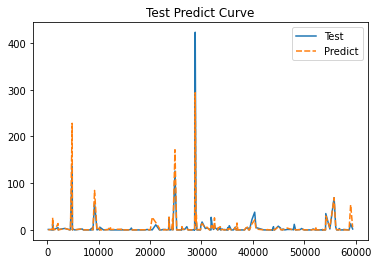

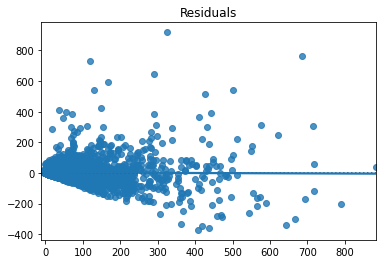

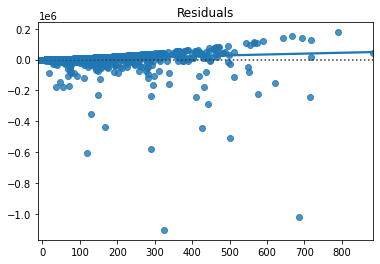

       Index        Mean
0    R2 Pred    0.750225
1         R2    0.750225
2         EV    0.750239
3         ME  909.565602
4    MEAN_AE    3.417070
5        MSE  256.299493
6  MEDIAN_AE    0.492478
7     HIT@10    0.936241
8    HIT@100    0.580000


In [14]:
train_final_model(max_depth=12, min_samples_split=0.0001, learning_rate=0.1, n_estimators=60)